In [47]:
import os
import ee
import geemap
import pycrs
import json
import os
import requests
# import shapely
from geemap import geojson_to_ee, ee_to_geojson
from ipyleaflet import GeoJSON
import geopandas as gpd
import matplotlib.pyplot as plt

In [48]:
band_dict = {
    "LANDSAT/LC08/C02/T1_TOA": {
        "B": "B2",
        "G": "B3",
        "R": "B4",
        "NIR": "B5",
        "SWIR1": "B6",
        "SWIR2": "B7",
        "PAN": "B8",
    },
    "LANDSAT/LE07/C02/T1_TOA": {
        "B": "B1",
        "G": "B2",
        "R": "B3",
        "NIR": "B4",
        "SWIR1": "B5",
        "SWIR2": "B7",
        "PAN": "B8",
    },
}

In [49]:
m = geemap.Map()

In [68]:
def geojson_to_ee_polygon(geojson: dict) -> ee.Geometry.Polygon:
    # Extract coordinates from the geojson
    features = geojson['features']
    polygons = []
    
    for feature in features:
        geometry = feature['geometry']
        if geometry['type'] == 'Polygon':
            # Extract 2D coordinates by removing the altitude (z) coordinate
            coordinates = [[(x, y) for x, y, _ in ring] for ring in geometry['coordinates']]
            polygons.append(coordinates)
            return ee.Geometry.Polygon(polygons[0])
        elif geometry['type'] == 'MultiPolygon':
            return(ee.Geometry.MultiPolygon(geometry['coordinates'])).dissolve()
        
    raise ValueError("No Polygon found in the provided GeoJSON")

def bbox(bounds: ee.Geometry.Polygon) -> list:
    xs = [x[0] for x in bounds._coordinates[0]]
    ys = [x[1] for x in bounds._coordinates[0]]
    return [min(xs), min(ys), max(xs), max(ys)]

In [69]:
def get_image(
    collection: str,
    bounds: ee.Geometry,
    temporal_filter: ee.Filter = None,
    cloud_threshold: int = 10,
    verbose: bool = True,
):
    image_set = ee.ImageCollection(collection).filterBounds(bounds)
    filtered_set = image_set.filter(ee.Filter.lt('CLOUD_COVER', cloud_threshold))
    if temporal_filter is not None:
        filtered_set = filtered_set.filter(temporal_filter)
    if verbose: 
        print(f"Images retrieved: {image_set.size().getInfo()}")
        print(f"Images after filters: {filtered_set.size().getInfo()}")

    return filtered_set

In [135]:
aoi_file = "southern_highlands.kml"
gdf = gpd.read_file(aoi_file, driver='LIBKML')
bounds = geojson_to_ee_polygon(gdf.__geo_interface__)
collection = "LANDSAT/LC08/C02/T1_TOA"
# collection = "LANDSAT/LE07/C02/T1_TOA"
cloud_threshold = 10

dry_set = get_image(
    collection, 
    bounds, 
    ee.Filter.calendarRange(6, 7, 'month'),
    cloud_threshold,
)

print()
wet_set = get_image(
    collection, 
    bounds, 
    ee.Filter.calendarRange(1, 2, 'month'),
    cloud_threshold,
)

Images retrieved: 4123
Images after filters: 294

Images retrieved: 4123
Images after filters: 62


In [136]:
def get_path_row(image):
    # Get WRS_PATH and WRS_ROW properties
    path = ee.Number(image.get('WRS_PATH'))
    row = ee.Number(image.get('WRS_ROW'))
    
    # Print or return the path-row as a dictionary for inspection
    return ee.Feature(None, {
        'WRS_PATH': path,
        'WRS_ROW': row
    })

# Map over the collection and get WRS path/row for each image
path_row_features = dry_set.map(get_path_row)

# Convert to a FeatureCollection to view all WRS paths and rows
path_row_collection = ee.FeatureCollection(path_row_features)

# Print to check the output (useful for debugging in Earth Engine code editor)
#print(path_row_collection.getInfo())
path_row_dict = {}
# print(len(path_row_collection.getInfo()['features']))
for feature in path_row_collection.getInfo()['features']:
    path = feature['properties']['WRS_PATH']
    row = feature['properties']['WRS_ROW']
    if (path, row) in path_row_dict:
        path_row_dict[path, row] += 1
    else:
        path_row_dict[path, row] = 1

Total images: 294
Camera positions: 16



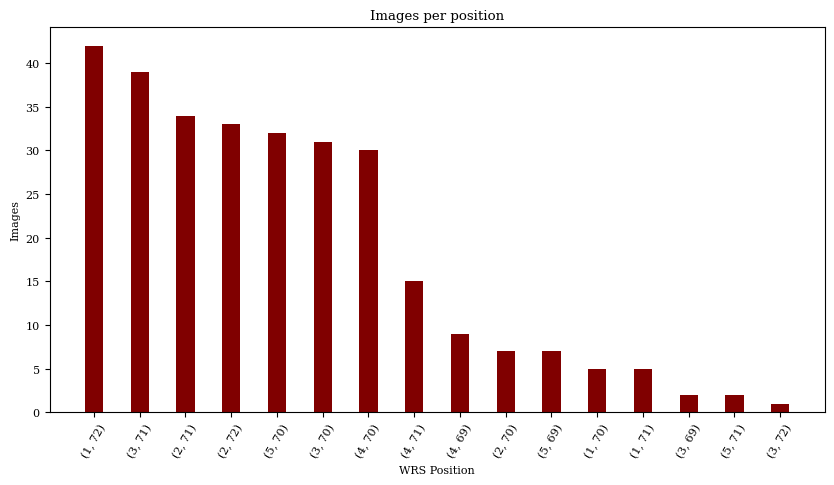

In [137]:
ocurrences = list(path_row_dict.values())
positions = list(path_row_dict.keys())
positions = [str(x) for x in positions]

data = list(zip(ocurrences, positions))
data.sort(key = lambda x: x[0], reverse = True)

positions = [x[1] for x in data]
occurrences = [x[0] for x in data]

print(f"Total images: {sum(occurrences)}")
print(f"Camera positions: {len(positions)}")
print()

fig = plt.figure(figsize = (10, 5))
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8
plt.bar(positions, occurrences, color ='maroon', width = 0.4)
plt.xticks(rotation=60)
plt.xlabel("WRS Position")
plt.ylabel("Images")
plt.title("Images per position")
plt.show()

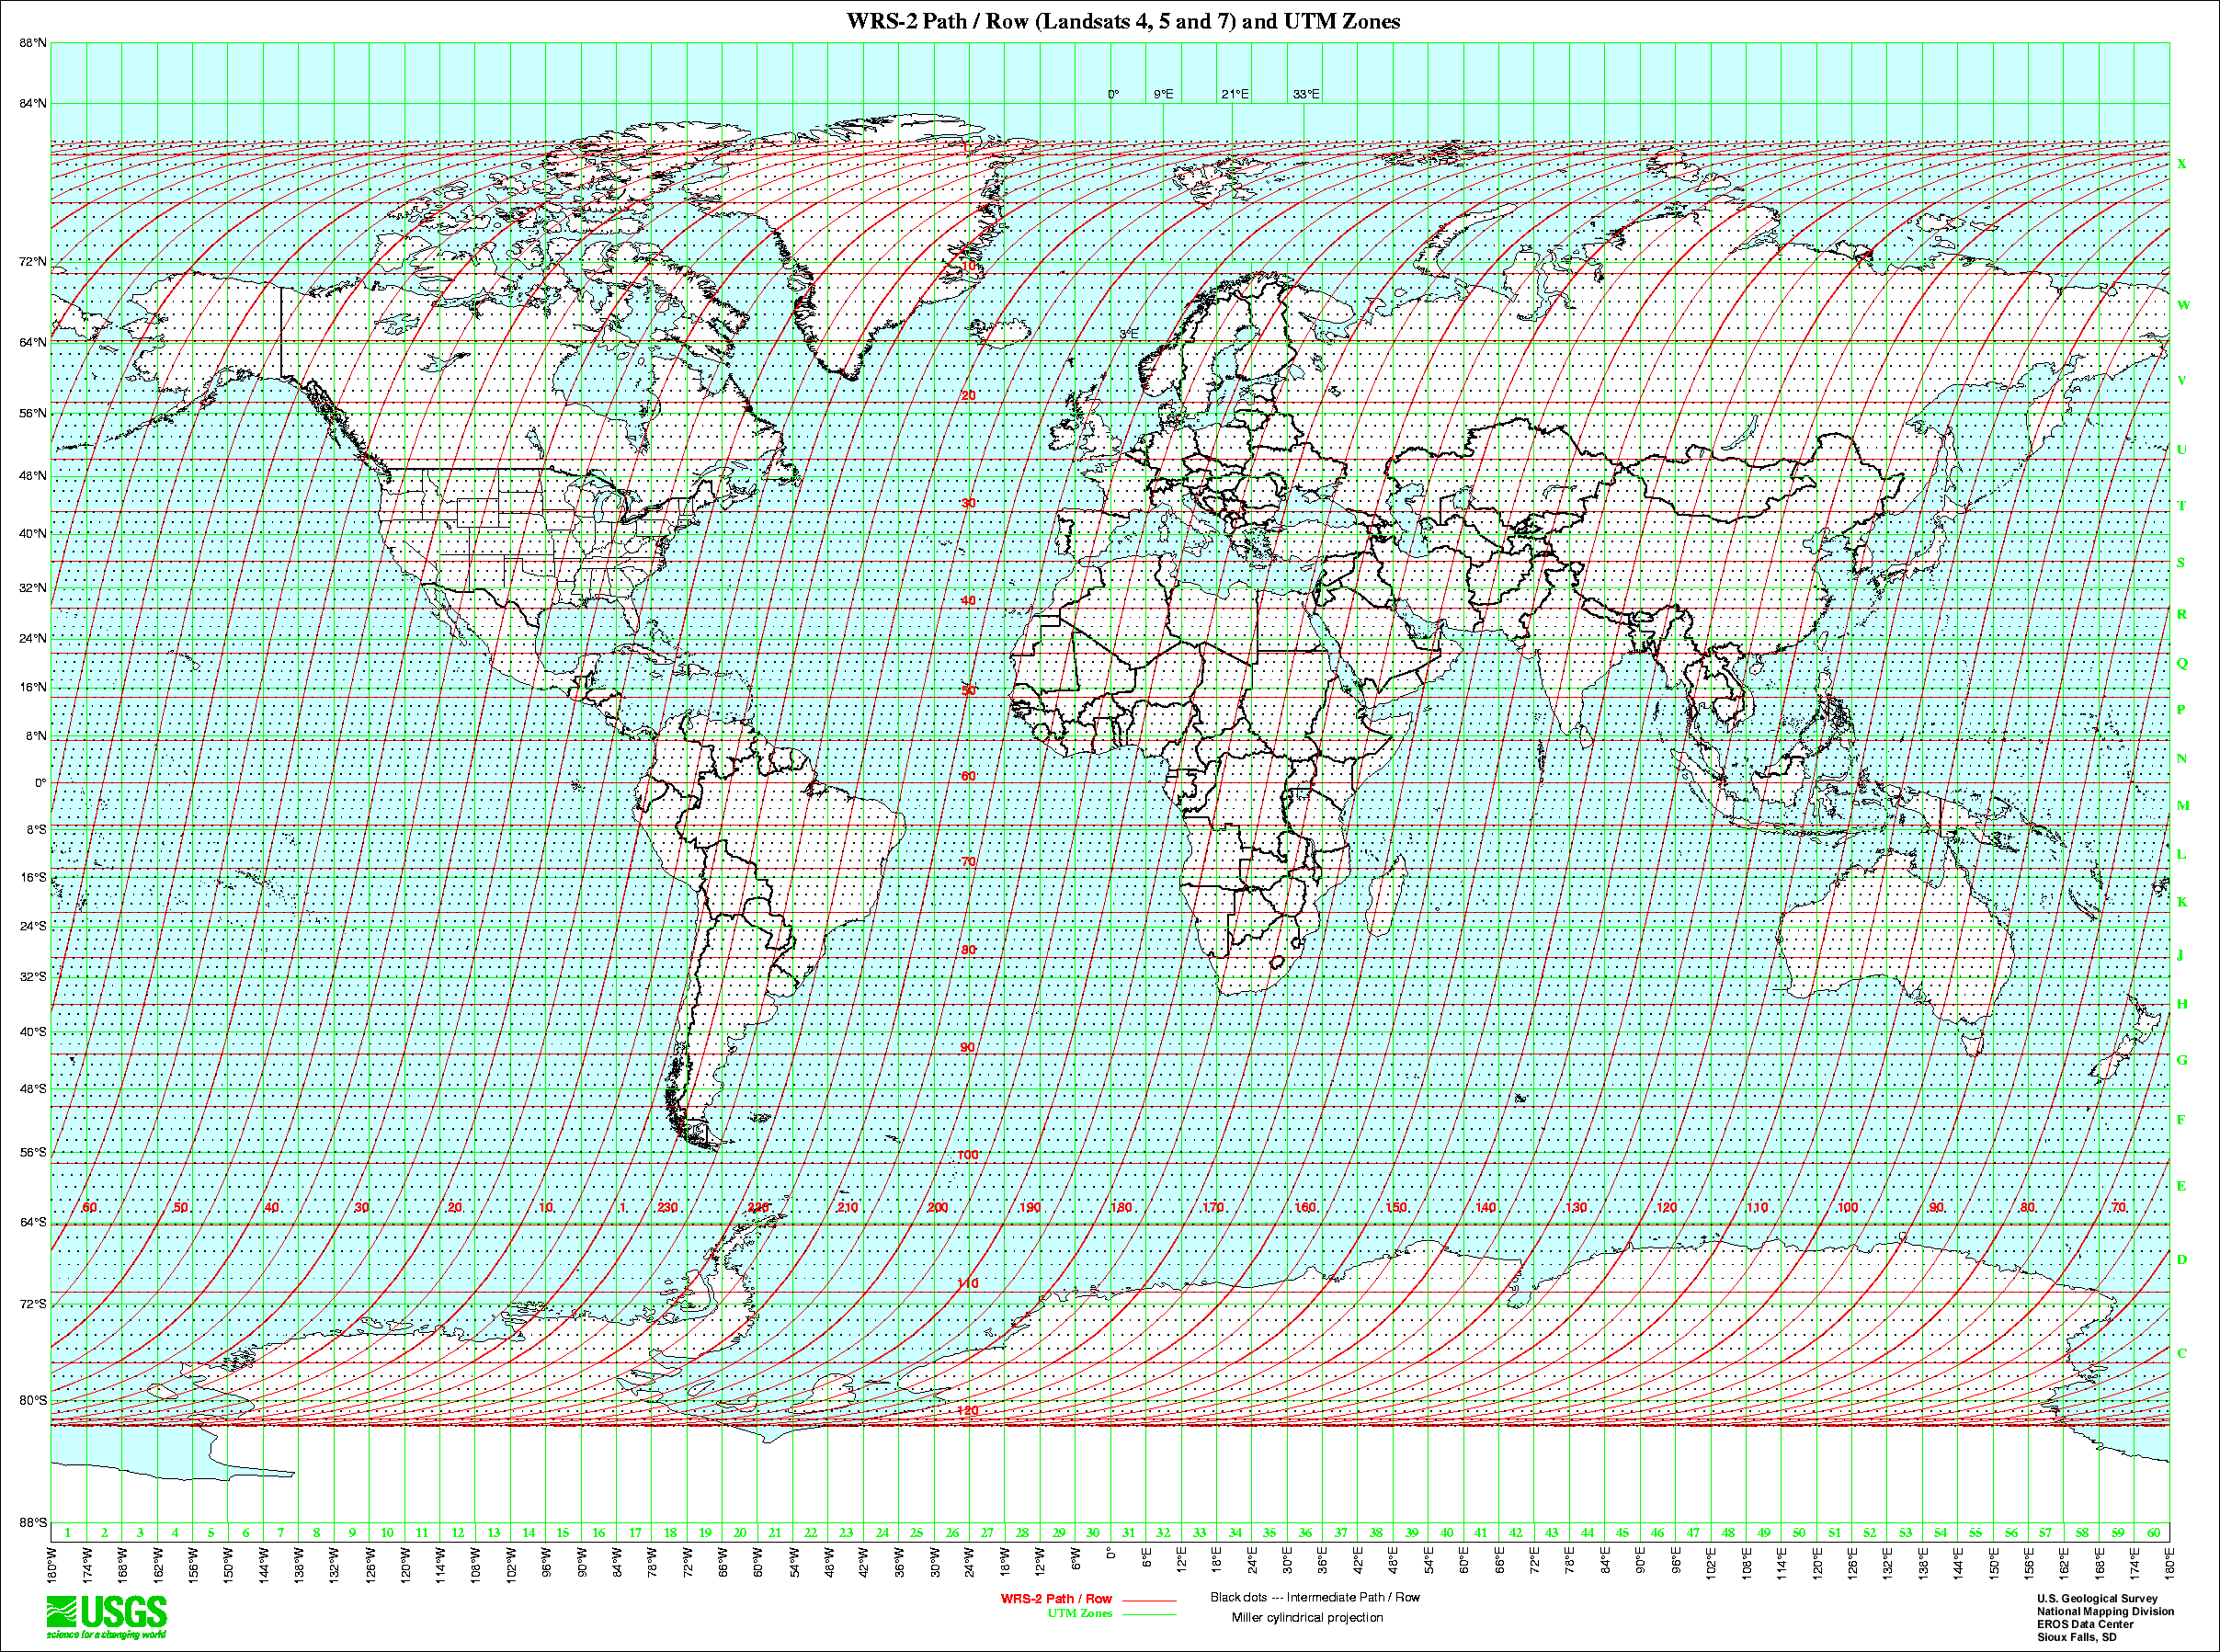

In [138]:
def calc_ndvi(
    image: ee.Image,
    collection: str,
) -> ee.Image:
    nir = band_dict[collection]["NIR"]
    red = band_dict[collection]["R"]
    return image.expression(
        '(NIR - RED) / (NIR + RED)',
        {
            'NIR': image.select(nir),
            'RED': image.select(red)
        }
    )

def calc_evi(
    image: ee.Image,
    collection: str,
) -> ee.Image:
    nir = band_dict[collection]["NIR"]
    red = band_dict[collection]["R"]
    blue = band_dict[collection]["B"]
    return image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {
            'NIR': image.select(nir),
            'RED': image.select(red),
            'BLUE': image.select(blue),
        },
)

In [139]:
dry_image = dry_set.median()
wet_image = wet_set.median()

dry_ndvi = calc_ndvi(dry_image, collection).rename("NDVI")
wet_ndvi = calc_ndvi(wet_image, collection).rename("NDVI")

dry_evi = calc_evi(dry_image, collection).rename("EVI")
wet_evi = calc_evi(wet_image, collection).rename("EVI")

In [140]:
m = geemap.Map()

ndvi_param = {
    'min': -1, 
    'max': 1, 
    'palette': ['red', 'yellow', 'green'],
    'bands': ['NDVI'],
}

evi_param = {
    'min': -1, 
    'max': 1, 
    'palette': ['a6611a', 'f5f5f5', '4dac26'],
    'bands': ['EVI'],
}

blue = band_dict[collection]["B"]
red = band_dict[collection]["R"]
green = band_dict[collection]["G"]

vis_param = {
  'bands': [red, green, blue],
  'min': 0,
  'max': 0.5,
  'gamma': [0.95, 1.1, 1]
}

m.addLayer(dry_ndvi, ndvi_param, 'Dry NDVI')
# m.addLayer(wet_ndvi, ndvi_param, 'Wet NDVI')
m.addLayer(dry_evi, evi_param, 'Dry EVI')
# m.addLayer(wet_evi, evi_param, 'Wet EVI')
m.addLayer(dry_image, vis_param, 'RBG')
m.addLayer(bounds)
m.centerObject(bounds, zoom = 5)
m

Map(center=[-15.420213224696669, -71.29369781528025], controls=(WidgetControl(options=['position', 'transparen…

In [105]:
def save_image(
    image: ee.Image,
    path: str,
    bounds: list,
    params: dict,
    resolution: int = 30
) -> None:
    geemap.ee_to_geotiff(image, path, bounds, vis_params=params, resolution = resolution, quiet=False)

In [106]:
# save_image(dry_ndvi, "southwest_survey_ndvi.tif", bbox(bounds), ndvi_param)


Downloaded image 1/12
Downloaded image 2/12
Downloaded image 3/12
Downloaded image 4/12
Downloaded image 5/12
Downloaded image 6/12
Downloaded image 7/12
Downloaded image 8/12
Downloaded image 9/12
Downloaded image 10/12
Downloaded image 11/12
Downloaded image 12/12
Saving GeoTIFF. Please wait...
Image saved to southwest_survey_ndvi.tif


In [146]:
# Export a cloud-optimized GeoTIFF.
task = ee.batch.Export.image.toDrive(
    image=dry_ndvi,
    description='southwest_survey_ndvi',
    region=bbox(bounds),
    fileFormat='GeoTIFF',
    formatOptions={'cloudOptimized': True},
    folder="Pastoralist Project",
    scale=30,
    maxPixels=1e9,
)
task.start()

In [147]:
# Export a cloud-optimized GeoTIFF.
task2 = ee.batch.Export.image.toDrive(
    image=dry_evi,
    description='southwest_survey_evi',
    region=bbox(bounds),
    fileFormat='GeoTIFF',
    formatOptions={'cloudOptimized': True},
    folder="Pastoralist Project",
    scale=30,
    maxPixels=1e9,
)
task2.start()

In [164]:
task.status()

{'state': 'COMPLETED',
 'description': 'southwest_survey_ndvi',
 'priority': 100,
 'creation_timestamp_ms': 1731451874598,
 'update_timestamp_ms': 1731452793177,
 'start_timestamp_ms': 1731451878367,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1kcF4jKvn10xlNTGZ4wR_d1xEfeK-Toul'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 11955.7919921875,
 'id': 'DWIKZXJ27EBL7WPWXD4ASMH5',
 'name': 'projects/135032319404/operations/DWIKZXJ27EBL7WPWXD4ASMH5'}

In [168]:
task2.status()

{'state': 'RUNNING',
 'description': 'southwest_survey_evi',
 'priority': 100,
 'creation_timestamp_ms': 1731451875048,
 'update_timestamp_ms': 1731453177091,
 'start_timestamp_ms': 1731451878367,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'batch_eecu_usage_seconds': 19434.366,
 'id': '7B3VQEN7O2LCEOVT5CU4GXDF',
 'name': 'projects/135032319404/operations/7B3VQEN7O2LCEOVT5CU4GXDF'}